In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression # Linear Regression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier # RandomForestClassifier
import datetime

In [3]:
%matplotlib inline
from sklearn.datasets import make_blobs

Step One

Importing Severe Weather Test Data

In [4]:
# importing test weather data
weather_df = pd.read_csv("SevereWeatherDetails_appended2.csv", low_memory=False)

In [5]:
weather_df.head()

,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,MAGNITUDE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,BEGIN_LAT,BEGIN_LON
0,10096222,OKLAHOMA,40,1950,April,Tornado,0,0,0,0,250K,0,0.0,0.0,F3,3.4,400.0,35.12,-99.20
1,10120412,TEXAS,48,1950,April,Tornado,0,0,0,0,25K,0,0.0,0.0,F1,11.5,200.0,31.90,-98.60
2,10104927,PENNSYLVANIA,42,1950,July,Tornado,2,0,0,0,25K,0,0.0,0.0,F2,12.9,33.0,40.58,-75.70
3,10104928,PENNSYLVANIA,42,1950,July,Tornado,0,0,0,0,2.5K,0,0.0,0.0,F2,0.0,13.0,40.60,-76.75
4,10104929,PENNSYLVANIA,42,1950,July,Tornado,0,0,0,0,2.5K,0,0.0,0.0,F0,0.0,33.0,41.63,-79.68


In [6]:
# reeeeeeee

weather_df['month'] = pd.to_datetime(weather_df.MONTH_NAME, format='%B').dt.month

In [7]:
# dropping columns not needed
weather_df = weather_df.drop(columns=['INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
                                     'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'MAGNITUDE', 'TOR_F_SCALE', 'TOR_LENGTH',
                                     'TOR_WIDTH', 'BEGIN_LAT', 'BEGIN_LON','CATEGORY', 'STATE', 'MONTH_NAME'])

In [8]:
weather_df.head()

,EVENT_ID,STATE_FIPS,YEAR,EVENT_TYPE,month
0,10096222,40,1950,Tornado,4
1,10120412,48,1950,Tornado,4
2,10104927,42,1950,Tornado,7
3,10104928,42,1950,Tornado,7
4,10104929,42,1950,Tornado,7


In [9]:
weather_df = weather_df.drop(weather_df[weather_df.YEAR > 2000].index)

In [10]:
# displaying weather df
weather_df.head()

,EVENT_ID,STATE_FIPS,YEAR,EVENT_TYPE,month
0,10096222,40,1950,Tornado,4
1,10120412,48,1950,Tornado,4
2,10104927,42,1950,Tornado,7
3,10104928,42,1950,Tornado,7
4,10104929,42,1950,Tornado,7


In [12]:
# adding together events by groups
group_groups = weather_df.groupby(['YEAR', 'month', 'STATE_FIPS', 'EVENT_TYPE'], as_index=False).count()
print(group_groups.head(10))
print(group_groups.tail(10))

   YEAR  month  STATE_FIPS EVENT_TYPE  EVENT_ID
0  1950      1           5    Tornado         1
1  1950      1          17    Tornado         3
2  1950      1          29    Tornado         2
3  1950      1          39    Tornado         1
4  1950      1          48    Tornado         1
5  1950      2           5    Tornado         2
6  1950      2          22    Tornado        11
7  1950      2          28    Tornado         2
8  1950      2          40    Tornado         1
9  1950      2          47    Tornado         2
       YEAR  month  STATE_FIPS    EVENT_TYPE  EVENT_ID
42496  2000     12          55    Heavy Snow        60
42497  2000     12          55  Winter Storm        27
42498  2000     12          56     Avalanche         3
42499  2000     12          56    Heavy Snow         8
42500  2000     12          56     High Wind        17
42501  2000     12          56  Winter Storm         5
42502  2000     12          96     High Surf         1
42503  2000     12          96  

In [13]:
# rename 'EVENT_ID' column as 'Count' and 'YEAR' as 'Year'
group_groups = group_groups.rename(columns={'EVENT_ID': 'Count', 'YEAR': 'Year'})
group_groups.head()

,Year,month,STATE_FIPS,EVENT_TYPE,Count
0,1950,1,5,Tornado,1
1,1950,1,17,Tornado,3
2,1950,1,29,Tornado,2
3,1950,1,39,Tornado,1
4,1950,1,48,Tornado,1


In [14]:
# Co2 Below This

In [15]:
# importing test co2 data 
carbon_df = pd.read_csv("co2_byYear.csv", low_memory=False)

In [16]:
# display co2 data
carbon_df

,year,co2,co2_per_capita,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,1950,23193.336,943.286,0.000,15959.768,272.887,223.550,1110.931,5611.231,9.976,...,0.000,0.00,0.000,0.00,0.000,7.570713e+09,1.585967e+13,0.000,0.000,0.000
1,1951,24765.194,1214.978,0.000,16981.583,309.265,243.305,1306.674,5907.881,11.002,...,0.000,0.00,0.000,0.00,0.000,7.712655e+09,7.992201e+12,0.000,0.000,0.000
2,1952,25203.424,834.737,0.000,16927.201,331.430,259.877,1405.429,6263.420,10.710,...,0.000,0.00,0.000,0.00,0.000,7.852545e+09,8.401431e+12,0.000,0.000,0.000
3,1953,25929.893,880.578,0.000,17104.163,368.454,248.979,1498.933,6689.993,12.910,...,0.000,0.00,0.000,0.00,0.000,7.992062e+09,8.884521e+12,0.000,0.000,0.000
4,1954,26744.552,1378.627,0.000,17319.801,400.182,236.584,1588.220,7182.609,11.442,...,0.000,0.00,0.000,0.00,0.000,8.133217e+09,9.099744e+12,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2016,124705.642,1156.831,44.924,48325.275,4990.527,1438.122,27011.160,41892.058,1048.509,...,1415.378,17424.08,345.519,6291.93,105.005,2.239131e+10,2.147076e+14,366170.181,5562418.068,208.589
67,2017,126304.716,1156.251,18.863,48587.789,5067.569,1576.265,27603.881,42412.614,1056.584,...,0.000,0.00,0.000,0.00,0.000,2.264281e+10,2.211738e+14,366923.317,3678183.705,0.000
68,2018,128452.538,1152.783,18.444,49368.748,5286.347,1531.205,28781.873,42422.168,1062.207,...,0.000,0.00,0.000,0.00,0.000,2.289184e+10,2.276454e+14,376507.961,3698476.648,0.000
69,2019,128422.887,1165.000,18.142,48731.161,5408.677,1611.674,29061.768,42547.578,1062.016,...,0.000,0.00,0.000,0.00,0.000,2.313895e+10,0.000000e+00,380148.487,3659567.475,0.000


In [17]:
# rename columns for merging purposes
carbon_df = carbon_df.rename(columns={"year": "Year"})
carbon_df

,Year,co2,co2_per_capita,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,1950,23193.336,943.286,0.000,15959.768,272.887,223.550,1110.931,5611.231,9.976,...,0.000,0.00,0.000,0.00,0.000,7.570713e+09,1.585967e+13,0.000,0.000,0.000
1,1951,24765.194,1214.978,0.000,16981.583,309.265,243.305,1306.674,5907.881,11.002,...,0.000,0.00,0.000,0.00,0.000,7.712655e+09,7.992201e+12,0.000,0.000,0.000
2,1952,25203.424,834.737,0.000,16927.201,331.430,259.877,1405.429,6263.420,10.710,...,0.000,0.00,0.000,0.00,0.000,7.852545e+09,8.401431e+12,0.000,0.000,0.000
3,1953,25929.893,880.578,0.000,17104.163,368.454,248.979,1498.933,6689.993,12.910,...,0.000,0.00,0.000,0.00,0.000,7.992062e+09,8.884521e+12,0.000,0.000,0.000
4,1954,26744.552,1378.627,0.000,17319.801,400.182,236.584,1588.220,7182.609,11.442,...,0.000,0.00,0.000,0.00,0.000,8.133217e+09,9.099744e+12,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2016,124705.642,1156.831,44.924,48325.275,4990.527,1438.122,27011.160,41892.058,1048.509,...,1415.378,17424.08,345.519,6291.93,105.005,2.239131e+10,2.147076e+14,366170.181,5562418.068,208.589
67,2017,126304.716,1156.251,18.863,48587.789,5067.569,1576.265,27603.881,42412.614,1056.584,...,0.000,0.00,0.000,0.00,0.000,2.264281e+10,2.211738e+14,366923.317,3678183.705,0.000
68,2018,128452.538,1152.783,18.444,49368.748,5286.347,1531.205,28781.873,42422.168,1062.207,...,0.000,0.00,0.000,0.00,0.000,2.289184e+10,2.276454e+14,376507.961,3698476.648,0.000
69,2019,128422.887,1165.000,18.142,48731.161,5408.677,1611.674,29061.768,42547.578,1062.016,...,0.000,0.00,0.000,0.00,0.000,2.313895e+10,0.000000e+00,380148.487,3659567.475,0.000


In [18]:
# dropping columns not needed
carbon_df = carbon_df.drop(columns=['co2_per_unit_energy', 'coal_co2', 'cement_co2', 'flaring_co2', 'gas_co2',
                                         'oil_co2', 'other_industry_co2', 'ghg_per_capita', 'methane', 'methane_per_capita',
                                         'nitrous_oxide', 'nitrous_oxide_per_capita', 'population', 'gdp', 'primary_energy_consumption',
                                         'energy_per_capita', 'energy_per_gdp', 'total_ghg'])

In [19]:
carbon_df = carbon_df.drop(carbon_df[carbon_df.Year > 2000].index)

In [20]:
# show new dataframe
carbon_df

,Year,co2,co2_per_capita
0,1950,23193.336,943.286
1,1951,24765.194,1214.978
2,1952,25203.424,834.737
3,1953,25929.893,880.578
4,1954,26744.552,1378.627
5,1955,29264.525,1214.075
6,1956,31190.093,1417.809
7,1957,32296.584,1096.454
8,1958,33117.274,996.436
9,1959,34633.663,1119.316


In [21]:
# Merge attempt one
combo_df = group_groups.merge(carbon_df, left_on='Year', right_on='Year')

In [22]:
# checking merge
combo_df

,Year,month,STATE_FIPS,EVENT_TYPE,Count,co2,co2_per_capita
0,1950,1,5,Tornado,1,23193.336,943.286
1,1950,1,17,Tornado,3,23193.336,943.286
2,1950,1,29,Tornado,2,23193.336,943.286
3,1950,1,39,Tornado,1,23193.336,943.286
4,1950,1,48,Tornado,1,23193.336,943.286
...,...,...,...,...,...,...,...
42501,2000,12,56,Winter Storm,5,92998.026,1174.210
42502,2000,12,96,High Surf,1,92998.026,1174.210
42503,2000,12,96,High Wind,1,92998.026,1174.210
42504,2000,12,97,High Surf,1,92998.026,1174.210


In [23]:
# Print out the # of yearly events value counts
count_counts = combo_df.Count.value_counts()
count_counts

1      11043
2       5905
3       3748
4       2830
5       2195
       ...  
368        1
241        1
544        1
311        1
447        1
Name: Count, Length: 273, dtype: int64

In [24]:
count_counts.head

<bound method NDFrame.head of 1      11043
2       5905
3       3748
4       2830
5       2195
       ...  
368        1
241        1
544        1
311        1
447        1
Name: Count, Length: 273, dtype: int64>

<AxesSubplot:ylabel='Density'>

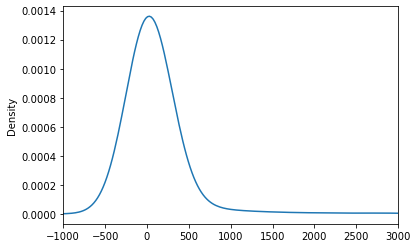

In [25]:
# Visualize the value counts
count_counts.plot.density(xlim=(-1000,3000))

In [26]:
# Determine which values to replace
replace_counts = list(count_counts[count_counts < 2].index)

# Replace in DataFrame
#for count in replace_counts:
#    combo_df.Count = combo_df.Count.replace(count,0)

# remove values that occur less than 3 times
combo_df = combo_df[~combo_df['Count'].isin(replace_counts)]


# Check to make sure binning was successful
combo_df.Count.value_counts()

1      11043
2       5905
3       3748
4       2830
5       2195
       ...  
205        2
173        2
218        2
212        2
159        2
Name: Count, Length: 200, dtype: int64

In [ ]:
# Adding machine learning model parameters below here

In [ ]:
# Convert the target column values to specific values

# x = dict.fromkeys(['Count'], 'Below Average')    
# combo_df = combo_df.replace(x)

# x = dict.fromkeys(['Count'], 'Above Average')    
# combo_df = combo_df.replace(x)

# combo_df.reset_index(inplace=True, drop=True)

# combo_df.head()

In [ ]:
target = ["Count"]

In [ ]:
# # Create the OneHotEncoder instance
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(sparse=False)

# # Fit the encoder and produce encoded DataFrame
# encode_df = pd.DataFrame(enc.fit_transform(combo_df.EVENT_TYPE.values.reshape(-1,1)))

# # Rename encoded columns
# encode_df.columns = enc.get_feature_names(['EVENT_TYPE'])
# encode_df.head()

In [ ]:
# # Merge the two DataFrames together and drop the Country column
# combo_df = combo_df.merge(encode_df,left_index=True,right_index=True).drop("EVENT_TYPE",1)

In [ ]:
combo_df.dtypes

In [32]:
# split data into training and testing

# Create our features
# X = pd.get_dummies(combo_df.drop(columns="EVENT_TYPE"))

X = combo_df.drop(columns=["Count", "co2_per_capita", "EVENT_TYPE" ])

# Create our target
y = combo_df["Count"]

In [33]:
y.describe()

count    42433.000000
mean        10.650084
std         20.281056
min          1.000000
25%          1.000000
50%          4.000000
75%         10.000000
max        414.000000
Name: Count, dtype: float64

In [34]:
# Check the balance of our target values
y = combo_df['Count']
y.value_counts()

1      11043
2       5905
3       3748
4       2830
5       2195
       ...  
205        2
173        2
218        2
212        2
159        2
Name: Count, Length: 200, dtype: int64

# BalancedRandomForestClassifier

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
Counter(y_train)

Counter({8: 877,
         1: 8282,
         14: 393,
         2: 4429,
         3: 2811,
         5: 1646,
         4: 2122,
         121: 3,
         15: 346,
         13: 446,
         67: 19,
         53: 36,
         33: 98,
         30: 121,
         28: 131,
         11: 552,
         59: 31,
         46: 52,
         22: 202,
         21: 222,
         10: 679,
         19: 229,
         23: 191,
         50: 52,
         7: 1049,
         41: 65,
         185: 2,
         12: 508,
         49: 38,
         32: 94,
         24: 182,
         144: 4,
         6: 1281,
         20: 252,
         18: 249,
         48: 48,
         9: 763,
         45: 56,
         40: 78,
         103: 6,
         44: 55,
         37: 77,
         29: 125,
         25: 152,
         16: 312,
         47: 51,
         86: 11,
         63: 25,
         88: 15,
         34: 97,
         17: 313,
         82: 13,
         105: 8,
         96: 10,
         145: 4,
         62: 26,
         31: 98,
     

In [36]:
# resample the training data with the BalancedRandomForestClassifier

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brfc.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(random_state=1)

In [37]:
# display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = brfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
# calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.0058823529411764705

In [39]:
# print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.00      0.00      1.00      0.00      0.00      0.00      2761
          2       0.00      0.00      1.00      0.00      0.00      0.00      1476
          3       0.00      0.00      1.00      0.00      0.00      0.00       937
          4       0.00      0.00      1.00      0.00      0.00      0.00       708
          5       0.00      0.00      1.00      0.00      0.00      0.00       549
          6       0.00      0.00      1.00      0.00      0.00      0.00       427
          7       0.00      0.00      1.00      0.00      0.00      0.00       350
          8       0.00      0.00      1.00      0.00      0.00      0.00       292
          9       0.00      0.00      1.00      0.00      0.00      0.00       255
         10       0.00      0.00      1.00      0.00      0.00      0.00       227
         11       0.00      0.00      1.00      0.00      0.00      0.00       184
   

In [40]:
# list the features sorted in descending order by feature importance
sorted(zip(brfc.feature_importances_, X.columns), reverse=True)

[(0.42356096755336176, 'STATE_FIPS'),
 (0.2765901160125734, 'month'),
 (0.15050352363505645, 'co2'),
 (0.1493453927990085, 'Year')]

# Easy Ensemble AdaBoost Classifier

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
Counter(y_train)

In [ ]:
# Train the EasyEnsembleClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier 

X, y = load_iris(return_X_y=True)
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
scores = cross_val_score(eec, X, y, cv=5)
scores.mean()

In [ ]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
eec.fit(X_train, y_train)

In [ ]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = eec.predict(X_test)
confusion_matrix(y_test, y_pred)

In [ ]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

In [ ]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))